# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

**%reload_ext autoreload**
- 만약에 어떤 라이브러리가 로드된 이후에 업데이트가 된 경우, 자동으로 업데이트된 코드를 불러와서 재실행해주는 코드.
**%autoreload 2**
- autoreload level을 2로 설정해주면, 파이썬 코드가 실행될때마다 reload를 함.
**%matplotlib inline**
- matplotlib에서 그래프가 출력될 때, 팝업창이 아닌 jupyter notebook안에 output cell로 출력되게 하기 위한 코드.

In [0]:
# %로 시작하는 코드들은 ipython-kernel에 설정을 바꿔주는 코드들.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *  # fastai에 있는 vision 관련 모든 함수 import.
from fastai.metrics import error_rate  # error_rate 계산 함수 import.

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9654506204972628277, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8178081504367741982
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11329170926902458929
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11078962381
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13653535653009132454
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
bs = 64  # batch_size를 64로 세팅. batch_size는 GPU memory 사용량과 직결되기 때문에, 16이나 32 부터 시작해서 체크해보는 것이 좋다. colab의 경우 GPU를 기본적으로 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
help(untar_data) # untar_data 함수에 대한 설명을 출력.

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [6]:
path = untar_data(URLs.PETS); path  # oxford-iiit-pet 데이터셋을 다운로드해서 압축 해제.

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()  # 현재 데이터셋이 제대로 압축해제 되어 있는지 ls 명령어를 통해 확인.

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
path_anno = path/'annotations'  # 이미지 경로를 변수로 지정.
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [9]:
fnames = get_image_files(path_img)   # get_image_files를 통해 다운로드 받은 이미지들의 파일이름 형식이 어떻게 되어있는지 확인함.
fnames[:5]  # 그중에 앞에 있는 5개를 print.

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_99.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_74.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_141.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_33.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_148.jpg')]

In [0]:
np.random.seed(2)  # 난수 생성에 필요한 seed를 설정함. 왜 하는지 모르겠음. 아마도 다른 fastai 함수들이 난수 생성을 할 때 자동으로 seed 설정을 해서 쓰기 때문에 한 것 같음.
pat = r'/([^/]+)_\d+.jpg$' # regular expression을 이용해서 필요한 데이터의 이름형식을 지정함. /로 시작해서 / 사이에 한글자 이상 존재하고 _숫자.jpg로 끝나는 형식의 텍스트를 의미함.

In [0]:
# regular expression을 이용하여 image를 가져오는 함수. batch_size는 64로, 위에서 지정한 정규표현식에 해당하는 이미지들을 가져오고, 이미지의 size는 224 x 224로 통일함. 그리고 이미지들 간의 편차를 줄이기 위해 모든 이미지를 normalize함. 각 픽셀(feature) 값을 0~1 사이로 바꿔줌.
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

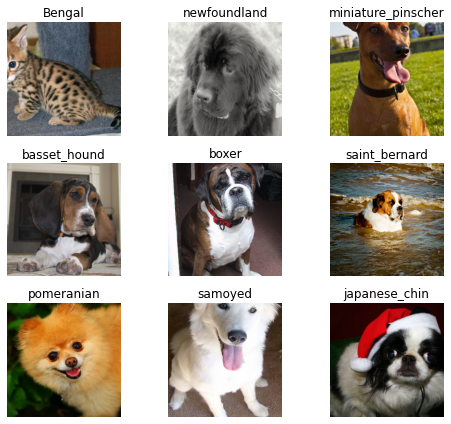

In [12]:
data.show_batch(rows=3, figsize=(7,6))  # row 3개로 7 x 6 size의 figure에다가 랜덤으로 이미지를 출력함.

In [13]:
print(data.classes)  # 불러온 데이터의 서로 다른 분류(class)를 보여줌.
len(data.classes),data.c # 그 클래스가 몇개 인지 출력함. data.classes 리스트의 길이와 data.c 는 같은 37을 출력함. 지금 사용하는 데이터는 37개의 class를 가지고 있음.

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [14]:
# fastai v3는 backend로 pytorch를 사용하기 때문에, pytorch repo에 있는 resnet34를 toy model로 사용하기 위해 불러옴.
learn = cnn_learner(data, models.resnet34, metrics=error_rate)  # 불러온 모델을 세팅. 위에서 불러온 데이터를 사용하고 error_rate를 evaluation metric으로 설정.

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [15]:
learn.model  # 학습!

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
learn.fit_one_cycle(4) # 총 4번의 epoch를 진행함. 출력되는 결과는 한 epoch 마다 train/validation loss, error_rate(1 - acc)와 학습에 사용된 시간을 출력함.

epoch,train_loss,valid_loss,error_rate,time
0,1.361350,0.291940,0.092016,01:42
1,0.607663,0.308951,0.096076,01:39
2,0.393770,0.224213,0.076455,01:45
3,0.278038,0.217833,0.071719,01:47


In [0]:
learn.save('stage-1')  # 학습 결과를 "stage-1"이라는 이름으로 저장함.

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [18]:
interp = ClassificationInterpretation.from_learner(learn)  # classification 결과를 쉽게 볼 수 있는 함수. 방금 전에 학습시킨 resnet34를 이용해서 test 결과를 확인하려는 용도로 사용함.

losses,idxs = interp.top_losses()   # 학습 결과 loss가 낮은 순서대로 정렬해서 그때의 loss값과 데이터의 idx를 돌려줌.

len(data.valid_ds)==len(losses)==len(idxs) # 길이가 모두 같으면 제대로 모든 데이터가 학습이 된 것.

True

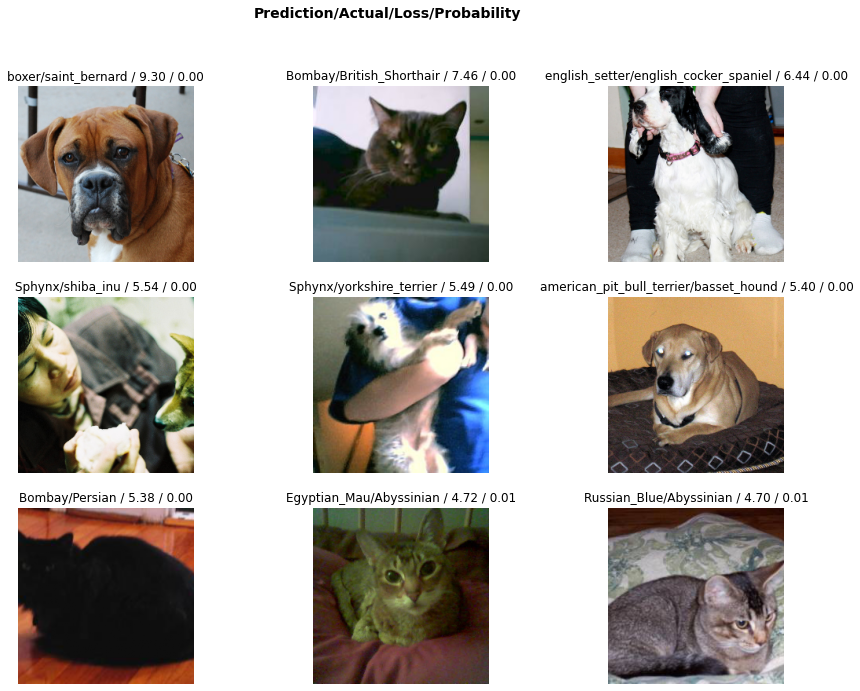

In [19]:
interp.plot_top_losses(9, figsize=(15,11)) # loss가 가장 적은 9개를 15, 11 사이즈에 걸쳐서 출력함.

In [20]:
doc(interp.plot_top_losses)  # interp.plot_top_losses 함수에 대한 docstring을 보여줌.

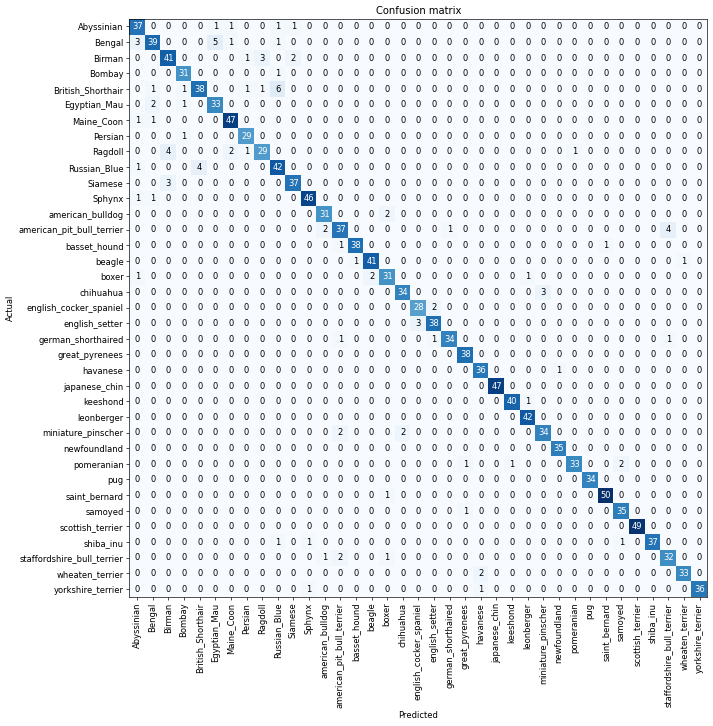

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # 학습한 결과에 대해서 confusion_matrix를 출력함. 총 39개의 classes에 대해서 얼마나 맞췄는지, 얼마나 틀렸는지, 틀렸다면 어떤 class로 predict 했는지 체크해볼 수 있다.

In [22]:
# 2개 이상 다르게 Predict한 클래스들에 대해 출력해본다. 결과를 보면 american_pit_bull_terrier를 staffordshire_bull_terrier로 8개나 잘못 predict한 것을 확인할 수 있다.
# 같은 pit_bull_terrier들이라 다른 종들에 비해 비교적 분류하기 힘들었을 것으로 추정한다.
interp.most_confused(min_val=2)

[('British_Shorthair', 'Russian_Blue', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Ragdoll', 'Birman', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Bengal', 'Abyssinian', 3),
 ('Birman', 'Ragdoll', 3),
 ('Siamese', 'Birman', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('Birman', 'Siamese', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Ragdoll', 'Maine_Coon', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('boxer', 'beagle', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('pomeranian', 'samoyed', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2),
 ('wheaten_terrier', 'havanese', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze() # unfreeze를 하면 학습했던 모델의 parameter를 update할 수 있다.

In [24]:
learn.fit_one_cycle(1) # 1 epoch를 더 진행한다. (총 5번의 epoch를 진행함.)

epoch,train_loss,valid_loss,error_rate,time
0,0.753668,0.393900,0.118403,01:52


In [0]:
learn.load('stage-1'); # 저장. semicolon은 왜 있는지 모르겠음.. 없어도됨.

In [26]:
learn.lr_find() # 학습 과정중에 loss 변화에 따른 learning rate의 변화를 보여줌.

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [0]:
?learn.lr_find()

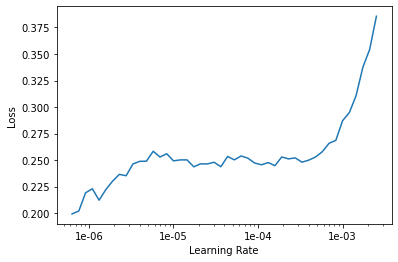

In [28]:
learn.recorder.plot() # lr에 따른 loss를 그린 그래프.

In [29]:
learn.unfreeze() # parameter update를 위해 unfreeze.
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4)) # 2 epoch를 진행하는데, lr을 1e-6에서 1e-4 사이로 지정해서 사용.

epoch,train_loss,valid_loss,error_rate,time
0,0.241318,0.212679,0.069689,01:52
1,0.224671,0.211484,0.069689,01:51


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

### Exercise2를 위해서 ResNet50 모델을 기준으로 Parameter를 바꿔보며 accuracy를 높여 보겠다.

In [0]:
# 이번에는 resnet34보다 residual layer가 더 많은 resnet50을 backbone으로 사용한다. (성능 향상을 예상하여 사용함. resnet에선 layer가 많을 수록 모델의 학습 능력도 향상됨.)
# 이번엔 size를 299로 바꾸고, bs는 64에서 32로 줄였다. (이유는 layer가 늘어났기 때문에, 메모리 사용량을 조절하기 위해서.)
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [31]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate) # resnet50 파이토치 모델을 다운로드 받고 모델 세팅.

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


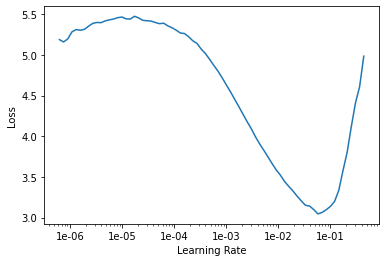

In [32]:
learn.lr_find()
learn.recorder.plot() # 적절한 LR을 찾기 위해 plot을 그려본다.

In [33]:
# 10 epoch로 resnet50 학습. 원래 예제인 8 epoch보다 epoch을 늘려서 error rate가 내려가는지 테스트해본다. (20 epoch가 너무 오래걸려서 도중에 중단하였다.)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.803863,0.269019,0.089310,03:17
1,0.526809,0.239087,0.080514,03:14
2,0.428950,0.254522,0.075778,03:13
3,0.363267,0.278295,0.086604,03:14
4,0.347165,0.231656,0.074425,03:14
5,0.342114,0.254078,0.077131,03:14
6,0.312879,0.212729,0.066982,03:15
7,0.227504,0.232175,0.073072,03:14
8,0.257787,0.199483,0.062246,03:15
9,0.164095,0.201759,0.064276,03:13


KeyboardInterrupt: ignored

In [0]:
learn.save('stage-1-50') # 모델 저장.

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [36]:
learn.unfreeze() # 모델의 fine-tuning을 위해서 unfreeze를 한뒤에.
learn.fit_one_cycle(3, max_lr=slice(1e-3,1e-1)) # LR의 범위를 재조정하며 3 epoch를 더 수행한다. 개인적인 생각으로 아예 처음 시작할때 recorder plot을 보고 max_lr을 지정해서 바로 하는게 더 빠를것 같다.

epoch,train_loss,valid_loss,error_rate,time
0,6.385421,8559.754883,0.976319,04:14
1,5.395516,1119.640015,0.967524,04:08
2,3.820621,88206.585938,0.959405,04:07


If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

In [39]:
interp.most_confused(min_val=3) # 다시 confusion_matrix를 통해서 mismatch가 난 케이스들을 살펴본다. 

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Birman', 'Ragdoll', 6),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Ragdoll', 'Birman', 3),
 ('Siamese', 'Birman', 3)]

## Other data formats

#### 다양한 타입의 데이터 포맷을 읽어오는 연습을 한다.

In [40]:
path = untar_data(URLs.MNIST_SAMPLE); path # 전설의 데이터 MNIST를 사용해본다. 위에는 동물 사진이고 이번엔 손글씨 데이터이다.

PosixPath('/root/.fastai/data/mnist_sample')

In [41]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/mnist_sample/train/3'),
 PosixPath('/root/.fastai/data/mnist_sample/train/7')]

In [0]:
tfms = get_transforms(do_flip=False) # 그림을 뒤집지 않고 여러 모양으로 변형한다.
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26) # 26 x 26 사이즈로 그림을 폴더에서 가져오는 함수.

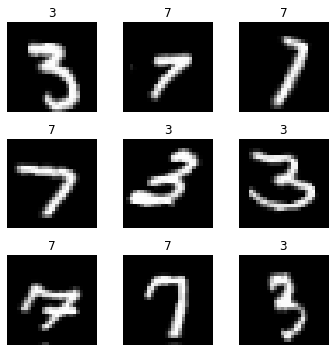

In [43]:
data.show_batch(rows=3, figsize=(5,5))

In [44]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy) # 이번엔 ResNet18 모델로 학습을 진행한다. MNIST는 동물 사진에 비해 특징을 찾기 쉬운 이미지이기 때문에 레이어가 적어도 충분히 높은 성능을 낼 수 있다.
learn.fit(2) # fit 함수로 바로 실행할 수 있으며, 첫번째 parameter로 epoch수가 들어간다. 2 epoch 학습.
# ResNet18로 2 epoch만 해도 acc가 0.987이 나옵니다. amazing!

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.208470,0.098394,0.967125,00:30
1,0.120898,0.044476,0.987242,00:28


In [45]:
df = pd.read_csv(path/'labels.csv') # 레이블이 저장되어 있는 csv 파일을 읽어온다.
df.head() # 앞에서부터 5줄 출력.

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28) #28 x 28 사이즈로 그림을 csv로부터 가져오는 함수.

[0, 1]

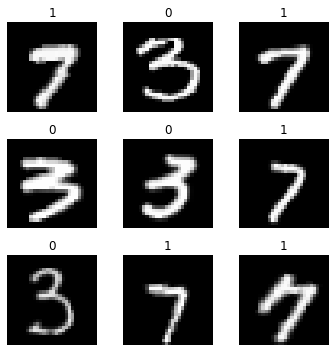

In [47]:
data.show_batch(rows=3, figsize=(5,5)) # 5x5 사이즈로 3x3의 그림을 출력.
data.classes

In [48]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24) # 24 x 24 사이즈로 그림을 DataFrame에서 가져오는 함수. (DataFrame은 pandas에서 제공되는 panel data 형식을 얘기함.)
data.classes

[0, 1]

In [49]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2] # 위에서 사용했던 것과 같은 방식. csv에서 불러온 name column에 있는 파일형식을 보고 불러옴.

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [50]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24) # 위에서 사용했던 방법과 똑같이 /와 숫자로 이루어진 패턴 뒤에 .png로 끝나는 파일들을 24 x 24 사이즈의 그림으로 가져옴.
data.classes

['3', '7']

In [51]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7') # lambda function을 사용해서 24 x 24 사이즈의 그림을 가져오는데, label이 3이나 7인 경우만을 포함함.
data.classes

['3', '7']

In [52]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths] # 이번엔 list comprehension을 이용해서 labels 라는 리스트에 label이 3이나 7인 파일경로만 남김.
labels[:5]

['3', '3', '3', '3', '3']

In [53]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24) # 위에서 만든 labels 리스트의 원소들을 파일경로로 하는 이미지를 24x24 사이즈로 불러옴.
data.classes

['3', '7']

## Comment :
- fastai를 사용해서 간단한 Image Classification을 진행하였다.
- fastai 라이브러리를 사용하면 keras나 pytorch를 통해서 구현하는것보다 훨씬 쉽게 사용할 수 있다.
- fastai의 함수들이 추상화가 상당히 잘되어있어서, 함수이름을 통해 이 함수가 어떤 역할을 하는지 거의 이해할 수 있었다.
- fastai의 backend로 pytorch를 사용하기 때문에 pythonic한 디자인이 잘 반영되어 있는 것 같다.
- ImageDataBunch 라는 함수가 다양한 format을 지원하기 때문에 일반 python을 구현할때처럼 그때마다 다른 함수를 가지고 와서 format을 맞출필요가 없다는게 굉장히 편했다. data format을 함수 이름 하나의 변형으로 맞춰서 만들었다는게 정말 대단했다.
- 굉장히 편하게 여러 CNN architecture들을 가져올 수 있었다. 이번 강의에서는 ResNet18, ResNet34, ResNet50을 사용했지만 documentation을 보니 VGGNet이나 Inception 모델 같은 다양한 CNN model들뿐만 아니라 RNN, LSTM, Transformer 등 대부분의 유명한 모델들은 전부 쉽게 사용할 수 있게 되어있었다. 물론 pytorch에 이미 구현체가 있기 때문에 가능한것 같지만.
- colab에 이미 fastai가 설치되어 있는 것도 굉장히 편했다. 구글드라이브에 해당 ipynb파일만 업로드해서 실행하면 무료로 고사양 GPU도 사용할 수 있어 딥러닝을 배우기 위한 진입장벽이 굉장히 낮다고 생각한다.
- 다만, 만약에 model 설계 자체를 바꾸고 싶거나 architecture의 세세한 구조나 activation function, optimizer를 조정하는건 더 헷갈릴 것 같다. 학습을 시키는 함수에 parameter로 다 포함되어 있긴한데 추상화가 되어있어 어떤 keyword argument를 넘겨주어야 하는지 documentation과 예제를 다 확인해봐야 알 수 있을 것 같다.